In [363]:
import numpy as np
import random
from tqdm.notebook import tqdm
import copy
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import scipy

In [364]:
class Environment(object):
    '''General RL environment'''

    def __init__(self):
        pass

    def reset(self):
        pass

    def advance(self, action):
        '''
        Moves one step in the environment.
        Args:
            action
        Returns:
            reward - double - reward
            newState - int - new state
            pContinue - 0/1 - flag for end of the episode
        '''
        return 0, 0, 0


def make_riverSwim(epLen=20, nState=5):
    '''
    Makes the benchmark RiverSwim MDP code by Ian Osband.
    Args:
        NULL - works for default implementation
    Returns:
        riverSwim - Tabular MDP environment '''
    nAction = 2
    R_true = {}
    P_true = {}
    states = {}
    for s in range(nState):
        states[(s)] = 0.0
        for a in range(nAction):
            R_true[s, a] = (0, 0)
            P_true[s, a] = np.zeros(nState)

    # Rewards
    R_true[0, 0] = (5/1000, 0)
    R_true[nState - 1, 1] = (1, 0)

    # Transitions
    for s in range(nState):
        P_true[s, 0][max(0, s-1)] = 1.

    for s in range(1, nState - 1):
        P_true[s, 1][min(nState - 1, s + 1)] = 0.3
        P_true[s, 1][s] = 0.6
        P_true[s, 1][max(0, s-1)] = 0.1

    P_true[0, 1][0] = 0.3
    P_true[0, 1][1] = 0.7
    P_true[nState - 1, 1][nState - 1] = 0.9
    P_true[nState - 1, 1][nState - 2] = 0.1

    riverSwim = TabularMDP(nState, nAction, epLen)
    riverSwim.R = R_true
    riverSwim.P = P_true
    riverSwim.states = states
    riverSwim.reset()

    return riverSwim



class TabularMDP(Environment):
    '''
    Tabular MDP
    R - dict by (s,a) - each R[s,a] = (meanReward, sdReward)
    P - dict by (s,a) - each P[s,a] = transition vector size S
    '''

    def __init__(self, nState, nAction, epLen):
        '''
        Initialize a tabular episodic MDP
        Args:
            nState  - int - number of states
            nAction - int - number of actions
            epLen   - int - episode length
        Returns:
            Environment object
        '''

        self.nState = nState
        self.nAction = nAction
        self.epLen = epLen

        self.timestep = 0
        self.state = 0

        # Now initialize R and P
        self.R = {}
        self.P = {}
        self.states = {}
        for state in range(nState):
            for action in range(nAction):
                self.R[state, action] = (1, 1)
                self.P[state, action] = np.ones(nState) / nState

    def reset(self):
        "Resets the Environment"
        self.timestep = 0
        self.state = 0

    def advance(self,action):
        '''
        Move one step in the environment
        Args:
        action - int - chosen action
        Returns:
        reward - double - reward
        newState - int - new state
        episodeEnd - 0/1 - flag for end of the episode
        '''
        if self.R[self.state, action][1] < 1e-9:
            # Hack for no noise
            reward = self.R[self.state, action][0]
        else:
            reward = np.random.normal(loc=self.R[self.state, action][0],
                                      scale=self.R[self.state, action][1])
        #print(self.state, action, self.P[self.state, action])
        newState = np.random.choice(self.nState, p=self.P[self.state, action])

        # Update the environment
        self.state = newState
        self.timestep += 1

        episodeEnd = 0
        if self.timestep == self.epLen:
            episodeEnd = 1
            #newState = None
            self.reset()

        return reward, newState, episodeEnd

    def argmax(self,b):
        #print(b)
        return np.random.choice(np.where(b == b.max())[0])

In [ ]:
class RLSVI(object):
    def __init__(self,env,K,sigma):
        self.env = env
        self.K = K
        self.sigma = sigma
        self.S = self.env.nState
        self.A = self.env.nAction
        self.H = self.env.epLen
        self.d = self.S * self.A
        self.Q = np.zeros((self.H+1,self.S,self.A))
        self.theta = np.zeros((self.H,self.d))
        self.lam = 0.01
        self.G = np.zeros((self.H,self.d,self.d))
        self.phi = np.identity(self.d)
        self.b = np.zeros((self.K,self.H,4))
        self.I = np.identity(self.d)
        
    
    def act(self,s,h):
        return self.env.argmax(self.Q[h,s,:])
    
    def update_buffer(self,s,a,r,s_,k,h):
        self.b[k,h,0] = s
        self.b[k,h,1] = a
        self.b[k,h,2] = r
        self.b[k,h,3] = s_
    
    def update(self,k):
        for h in range(self.H-1,-1,-1):
            
            self.sums_1 = np.zeros((self.d,self.d))
            self.sums_2 = np.zeros(self.d)
            for l in range(k):
                #Z = np.random.binomial(m_h,0.5)
                s,a,r,s_ = self.b[l,h,0],self.b[l,h,1],self.b[l,h,2],self.b[l,h,3]
                row = int(s*self.A + a)
                self.sums_1 = self.sums_1 + np.outer(self.phi[row,:],self.phi[row,:])
                self.sums_2 = self.sums_2 + self.phi[row,:]*(r + max(self.Q[h+1,int(s_),:]))
            self.G[h] = 1/pow(self.sigma,2)*self.sums_1 + self.lam*self.I
            Ginv = np.linalg.inv(self.G[h])
            temp = 1/pow(self.sigma,2)*np.dot(Ginv,self.sums_2)
            self.theta[h] = np.random.multivariate_normal(temp,Ginv)
            for ss in range(self.S):
                for aa in range(self.A):
                    row = int(ss*self.A + aa)
                    self.Q[h,ss,aa] = max(0,min(np.inner(self.theta[h],self.phi[row,:]),self.H))
    
    def run(self):
        Rvec = []
        R = 0
        for k in tqdm(range(self.K)):
            self.env.reset()
            done = 0
            while not done:
                s = self.env.state
                h = self.env.timestep
                a = self.act(s,h)
                r,s_,done = self.env.advance(a)
                self.update_buffer(s,a,r,s_,k,h)
                R += r
            Rvec.append(R)
            self.update(k)
        return Rvec
        

In [536]:
class LSVI_PHE(object):
    def __init__(self,env,K,v):
        self.env = env
        self.K = K
        self.v = v
        self.S = self.env.nState
        self.A = self.env.nAction
        self.H = self.env.epLen
        self.d = self.S * self.A
        self.Q = np.zeros((self.H+1,self.S,self.A)) 
        self.Q[self.H] = 0.0
        self.theta = np.zeros((self.H,self.d))
        self.lam = 0.01 
        self.G = np.zeros((self.H,self.d,self.d))
        self.phi = np.identity(self.d)
        self.b = np.zeros((self.K,self.H,4))
        self.I = np.identity(self.d)
        
    
    def act(self,s,h):
        c = np.random.uniform()
        if c < 1.0:
            return self.env.argmax(self.Q[h,s,:])
        else:
            return 1
    
    def update_buffer(self,s,a,r,s_,k,h):
        self.b[k,h,0] = s
        self.b[k,h,1] = a
        self.b[k,h,2] = r
        self.b[k,h,3] = s_
    
    def update(self,k):
        #print(self.Q)
        for h in range(self.H-1,-1,-1):
            #m_h = int(np.ceil(self.v*(self.H - h)))
            m_h = int(self.v)
            
            self.sums_1 = np.zeros((self.d,self.d))
            self.sums_2 = np.zeros(self.d)
            for l in range(k):
                Z = np.random.binomial(m_h,0.5) - m_h
                #print(Z)
                s,a,r,s_ = self.b[l,h,0],self.b[l,h,1],self.b[l,h,2],self.b[l,h,3]
                row = int(s*self.A + a)
                self.sums_1 = self.sums_1 + np.outer(self.phi[row,:],self.phi[row,:])
                self.sums_2 = self.sums_2 + self.phi[row,:]*(r + max(self.Q[h+1,int(s_),:]) + Z)
            self.G[h] = self.sums_1 + self.lam*self.I
            self.theta[h] = np.dot(np.linalg.inv(self.G[h]),self.sums_2)
            for ss in range(self.S):
                for aa in range(self.A):
                    #Z = np.random.normal(0.0,self.v)
                    row = int(ss*self.A + aa)
                    self.Q[h,ss,aa] = max(-self.H*m_h,min(np.inner(self.theta[h],self.phi[row,:]),0.0))
    
    def run(self):
        Rvec = []
        R = 0
        for k in tqdm(range(self.K)):
            self.env.reset()
            done = 0
            while not done:
                s = self.env.state
                h = self.env.timestep
                a = self.act(s,h)
                r,s_,done = self.env.advance(a)
                self.update_buffer(s,a,r,s_,k,h)
                R += r
            Rvec.append(R)
            if k > max(self.H,self.d):
                self.update(k)
        return Rvec
        

In [537]:
K = 1000
env = make_riverSwim(epLen = 20,nState = 6)

'''
agent1 = RLSVI(env,K,1.0)
R1 = agent1.run()
'''
agent = LSVI_PHE(env,K,1.0)
R = agent.run()

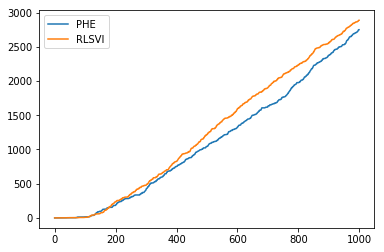

In [538]:
plt.plot(R,label = 'PHE')
plt.plot(R1[0:K],label = 'RLSVI')
plt.legend()
plt.show()

In [539]:
agent.Q[0,0,0] - agent.Q[0,0,1]

-0.27076498837593466

In [540]:
agent1.Q[0,0,0] - agent1.Q[0,0,1]

-0.26335815902965365

In [541]:
agent.Q

array([[[-8.25613278, -7.98536779],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[-8.03808898, -7.73819681],
        [-8.1070902 , -7.39753138],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[-7.7254559 , -7.57486489],
        [-7.62235148, -7.15365958],
        [-6.91877538, -6.08552639],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[-7.55299317, -7.2953701 ],
        [-7.6848104 , -6.95336925],
        [-7.14190934, -5.87632782],
        [-6.20953011, -4.05922222],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[-7.17425592, -7.04227205],
        [-7.17601816, -6.67761888],
        [-6.86325366, -5.74057776],
        [-5.51756589